In [2]:
!pip install opencv-python

In [9]:
import cv2
import os.path
import matplotlib.pyplot as plt

In [7]:
source_path = './anaselmasry/source'
positive_path = os.path.join(source_path, 'positive_Covid-19')
negative_path = os.path.join(source_path, 'negative_Covid-19')
default_negative_filename = os.path.join(negative_path, 'negative_0_641.jpg')
default_positive_filename = os.path.join(positive_path, 'positive_0_117.jpg')

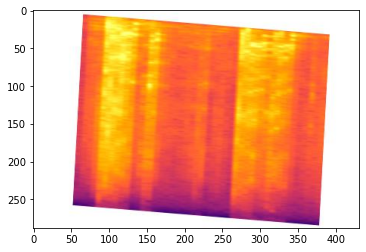

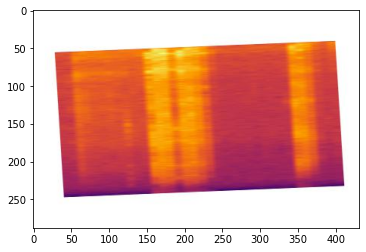

In [13]:
def loadImgRGB(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
negative_img = loadImgRGB(default_negative_filename)
positive_img = loadImgRGB(default_positive_filename)
plt.figure()
plt.imshow(negative_img)
plt.figure()
plt.imshow(positive_img)


In [16]:
def loadImgGray(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def findContours(filename):
    img = loadImgGray(filename)
    ret, thr = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY_INV)
    contours, hier = cv2.findContours(thr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

negative_contours = findContours(default_negative_filename)
positive_contours = findContours(default_positive_filename)
display(negative_contours)

[array([[[103,  74]],
 
        [[104,  75]],
 
        [[103,  76]],
 
        [[104,  75]],
 
        [[106,  75]],
 
        [[107,  76]],
 
        [[108,  76]],
 
        [[109,  77]],
 
        [[111,  77]],
 
        [[111,  76]],
 
        [[112,  75]],
 
        [[119,  75]],
 
        [[104,  75]]], dtype=int32),
 array([[[112,  71]],
 
        [[114,  71]]], dtype=int32),
 array([[[304,  50]]], dtype=int32),
 array([[[112,  47]],
 
        [[112,  48]],
 
        [[113,  48]]], dtype=int32),
 array([[[102,  47]],
 
        [[103,  47]],
 
        [[104,  48]],
 
        [[106,  48]],
 
        [[107,  47]]], dtype=int32),
 array([[[283,  41]]], dtype=int32),
 array([[[104,  12]]], dtype=int32),
 array([[[ 66,   6]],
 
        [[ 66,  17]],
 
        [[ 65,  18]],
 
        [[ 65,  35]],
 
        [[ 64,  36]],
 
        [[ 64,  54]],
 
        [[ 63,  55]],
 
        [[ 63,  72]],
 
        [[ 62,  73]],
 
        [[ 62,  91]],
 
        [[ 61,  92]],
 
        [[ 61, 109]],